<a href="https://colab.research.google.com/github/ymourilab/mouri/blob/master/almost_ok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fbcotter/pytorch_wavelets
!pip install ./pytorch_wavelets/.

fatal: destination path 'pytorch_wavelets' already exists and is not an empty directory.
Processing ./pytorch_wavelets
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.1.0-cp36-none-any.whl size=46100 sha256=410396aa0b247668e298d1e824d64c0725d184a58c0f5c0fb932de23a33172b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-lz0s5vrc/wheels/82/e1/5b/16a4e6ccfc0bb2ce14bd2796adb13e6e9b718cb7d2e1ae3643
Successfully built pytorch-wavelets
  Found existing installation: pytorch-wavelets 1.1.0
    Uninstalling pytorch-wavelets-1.1.0:
      Successfully uninstalled pytorch-wavelets-1.1.0


In [2]:
!git clone https://github.com/zh217/torch-dct
!pip install ./torch-dct/.

fatal: destination path 'torch-dct' already exists and is not an empty directory.
Processing ./torch-dct
  Created wheel for torch-dct: filename=torch_dct-0.1.5-cp36-none-any.whl size=4997 sha256=d7420973e54bea0c06376aa1c51358409899ece3cfc70a0d085f8b3717b5a492
  Stored in directory: /root/.cache/pip/wheels/54/af/7d/bfc942607a03ab314a2c757dae2f27d25d9698e9ed106890ed
Successfully built torch-dct
  Found existing installation: torch-dct 0.1.5
    Uninstalling torch-dct-0.1.5:
      Successfully uninstalled torch-dct-0.1.5


In [0]:
#!git clone https://github.com/tsakailab/spmlib
#!pip install ./spmlib/.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%ls gdrive/My\ Drive/mouri

 cloned-repo/        'ok.ipynb のコピー'                uista.ipynb
 coa_5k_F.wav         sample_F.wav                      Untitled0.ipynb
 coa_5k.wav           sample.wav                        卒研用.gdoc
 coa_5k_W.wav         sample_W.wav                      毛利卒論.gdoc
 Haion_recognition/   test_dct_wavelet.ipynb
 ok.ipynb             try_uISTA_for_lung_sounds.ipynb


In [6]:
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.3.1
True
cuda


In [7]:
import torch_dct as tdct
from pytorch_wavelets import DWTForward, DWTInverse
import torch

class uISTA(torch.nn.Module):

    def __init__(self, num_unroll, l=1.0, scale=1., prox=None, wt=None, iwt=None):
        super(uISTA, self).__init__()
        self.num_unroll = num_unroll #unroll回数
        #self.A = torch.nn.Parameter(torch.FloatTensor(A), requires_grad=True)#fhみたいなのに変更する
        self.l = torch.nn.Parameter(torch.FloatTensor([l]), requires_grad=True).to(device=device)#なんか配列作ってる多分なんかの計算用theta
        self.scale = scale#thetaの計算に使ってる
        print(device)
        if prox is None:
            self.prox = lambda z, th: z.sign() * (z.abs_() - th).max(torch.tensor(0, device=device).float())
            #zの値を0か負(=-1)か正(=1)か判定したやつとsoft閾値処理したやつの乗算
        else:
            self.prox = prox

        if wt is None:
            self.wt = DWTForward(J=3,wave='db10',mode='zero')
        else:
            self.wt = wt

        if iwt is None:
            self.iwt = DWTInverse(wave='db10', mode='zero')
        else:
            self.iwt = iwt

    def forward(self, b):
        theta = torch.mul(self.l, self.scale)#lの要素をscale倍するらしい
        w_theta = torch.mul(self.l, self.scale).div(10)
        # prox(A.dot(b*scale), theta) for initial guess of x xの初期値を決めるよ
        #x = self.prox(b.mul(self.scale).matmul(self.A), theta)    #matmulをidctにidwtに
        #x = self.prox(self.tidct(b.mul_(self.scale)), theta)
        x = self.prox(self.tdct(b.mul_(self.scale)), theta)
        plt.plot(torch.arange(0,len(x[0])).cpu(),x[0].cpu().detach().numpy())
        print(1111111)
        #coeffs = self.dwt(b.reshape(1,1,1,-1))
        w = self.w_softshrink(self.dwt(b.reshape(b.size()[0],1,1,-1)), w_theta)
        plt.plot(torch.arange(0,w[0].size()[3]).cpu(),w[0][0][0][0].cpu().detach().numpy())
        print("理想",type(w),self.dwt(b.reshape(b.size()[0],1,1,-1))[0].size())
        print("b",type(b),b.size(),b.size()[0])
        print("w[0]",w[0].size(),"1",[i.size() for i in w[1]])
        #self.dwt(w)[0].mul_(self.scale),[i.mul_(self.scale)for i in self.dwt(w)[1]])
        #w = self.w_softshrink(self.idwt(self.idwt(self.dwt(b.reshape(1,1,1,-1)))), theta)
        #w = torch.zeros(1,1,1,len(b[0]))
        #w = b.reshape(b.size()[0],1,1,-1)
        #print(x.size(),w.size())
        for i in range(self.num_unroll):
            #x = prox(x+A.T.dot(b-A.dot(x))*scale, theta) ISTAの繰り返し部分
            #x = soft(x + AT(b - Ax))scale
            #x = self.prox(x + (b - x.matmul(self.A.t())).mul_(self.scale).matmul(self.A), theta)
            #x = self.prox(x + r.mul_(self.scale).matmul(self.A), theta)  r = b-Ax
            #x = self.prox(x + At(r*scale), theta)
            x = self.prox(x + self.tdct(b - self.tidct(x.mul_(self.scale))), theta)
            print(i)
            print('after f')
            print("w",w[0].shape,[i.shape for i in w[1]])
            print("ato")
            #[x * y for (x, y) in zip(li1, li2)]
            #+ self.dwt(b.reshape(b.size()[0],1,1,-1) - self.idwt(w).mul_(self.scale))[0],\
            w = self.w_softshrink((w[0] \
                                   ,[v - u for (v, u) in zip(w[1], self.dwt(b.reshape(b.size()[0],1,1,-1) - self.idwt(w).mul_(self.scale))[1])]), w_theta)
            print("koeta")
        return x,w

    #関数AとATのかわり
    def tdct(self,x):
        return tdct.dct(x)
    
    def tidct(self,x):
        return tdct.idct(x)

    def dwt(self,x):
        return self.wt(x)

    def idwt(self,x):
        return self.iwt((x[0],x[1]))

    def w_softshrink(self,x,th):
        print("soft",type(x),x[0].size())
        return self.prox(x[0],th),[self.prox(i,th) for i in x[1]]

#    def add_b_iwt(self,x,b):
#        for i in range(x[0].size()[0]):
#            b[i][0][0] - self.idwt(w)[i][0][0].mul_(self.scale)
#        return x
"""
    #%% sign function compatible with complex values
    def sgn(z):
        return torch.div(z, z.abs())

    #%% soft thresholding function compatible with complex values
    def f_softshrink(z, th):
        return sgn(z) * torch.max(z.abs() - th, torch.tensor([0]).float())
        """

'\n    #%% sign function compatible with complex values\n    def sgn(z):\n        return torch.div(z, z.abs())\n\n    #%% soft thresholding function compatible with complex values\n    def f_softshrink(z, th):\n        return sgn(z) * torch.max(z.abs() - th, torch.tensor([0]).float())\n        '

In [0]:
softm = lambda z, th: z.sign() * torch.max(z.abs() - th, torch.tensor([0]).float())

In [0]:
def sgn(z):
    return torch.div(z, z.abs())

#%% soft thresholding function compatible with complex values
def f_softshrink(z, th):
    return sgn(z) * torch.max(z.abs() - th, torch.tensor([0]).float())

In [0]:
def read_file(filename):
    #read
    if os.path.exists(filename + '.wav') == False:
        Fs, input_data  = swf.read(filename + '.WAV')
    else:
        Fs, data = swf.read(filename + '.wav')
    
    #normalize between -1 and 1, change dtype double
    data = data.astype(np.float64)
    data = data / 32768.0
    print(Fs)
    print(data.shape)
    plt.subplot(3,1,1)
    plt.plot(np.arange(0,len(data)),data)
    return Fs,data

5000
(237333,)


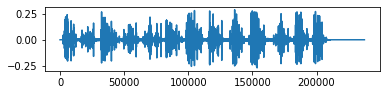

In [11]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt
from time import time
import os
import scipy.io.wavfile as swf

a = read_file('./gdrive/My Drive/mouri/coa_5k')[1]
a = np.concatenate((a,np.zeros(262144-len(a))),axis=0)
data = torch.arange(0,len(a))

In [12]:
input_data = torch.from_numpy(a).view(1,-1)
print(input_data.size())
print(type(input_data))

torch.Size([1, 262144])
<class 'torch.Tensor'>


In [13]:
input_data = torch.tensor(input_data, dtype=torch.float).to(device=device)
print(input_data.size())
#true

torch.Size([1, 262144])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [14]:
model = uISTA(30).to(device=device)
model.cuda()
print(model.named_parameters())
print(model.parameters())

cuda
<generator object Module.named_parameters at 0x7fa53709e570>
<generator object Module.parameters at 0x7fa53709e570>


In [15]:
print('Is model parameters on GPU? :', next(model.parameters()).is_cuda)
for param in model.parameters():
    print(type(param.data), param.size(), ', is_cuda:', param.is_cuda)

Is model parameters on GPU? : True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 20, 1]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True
<class 'torch.Tensor'> torch.Size([1, 1, 1, 20]) , is_cuda: True


1111111
soft <class 'tuple'> torch.Size([1, 1, 16, 32784])
理想 <class 'tuple'> torch.Size([1, 1, 16, 32784])
b <class 'torch.Tensor'> torch.Size([1, 262144]) 1
w[0] torch.Size([1, 1, 16, 32784]) 1 [torch.Size([1, 1, 3, 10, 131081]), torch.Size([1, 1, 3, 14, 65550]), torch.Size([1, 1, 3, 16, 32784])]
0
after f
w torch.Size([1, 1, 16, 32784]) [torch.Size([1, 1, 3, 10, 131081]), torch.Size([1, 1, 3, 14, 65550]), torch.Size([1, 1, 3, 16, 32784])]
ato
soft <class 'tuple'> torch.Size([1, 1, 16, 32784])
koeta
1
after f
w torch.Size([1, 1, 16, 32784]) [torch.Size([1, 1, 3, 10, 131081]), torch.Size([1, 1, 3, 14, 65550]), torch.Size([1, 1, 3, 16, 32784])]
ato
soft <class 'tuple'> torch.Size([1, 1, 16, 32784])
koeta
2
after f
w torch.Size([1, 1, 16, 32784]) [torch.Size([1, 1, 3, 10, 131081]), torch.Size([1, 1, 3, 14, 65550]), torch.Size([1, 1, 3, 16, 32784])]
ato
soft <class 'tuple'> torch.Size([1, 1, 16, 32784])
koeta
3
after f
w torch.Size([1, 1, 16, 32784]) [torch.Size([1, 1, 3, 10, 131081]), t

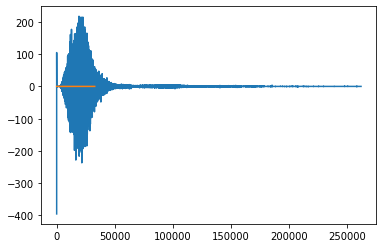

In [16]:
model_out = model.forward(input_data)

xの結果
 tensor([-395.1656,  -60.1948,  104.8709,  ...,    0.0000,    0.0000,
           0.0000], grad_fn=<SelectBackward>)
スパース解xをつかって求めた波形
 tensor([-0.0005, -0.0006, -0.0007,  ...,  0.0004,  0.0003,  0.0003],
       grad_fn=<ViewBackward>)
元のフーリエ
 tensor([-3.9617e+02, -6.1195e+01,  1.0587e+02,  ...,  4.8587e-01,
         2.0900e-01,  4.1924e-01])
<class 'torch.Tensor'>


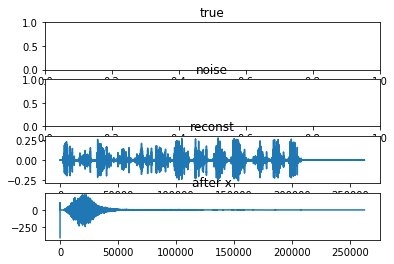

In [17]:
j = 0
print("xの結果\n",model_out[0][j])
print("スパース解xをつかって求めた波形\n",tdct.idct(model_out[0][j]))
print("元のフーリエ\n",tdct.dct(input_data[j]))
check = tdct.idct(model_out[0][j])
print(type(check))
plt.subplot(4,1,1)
plt.title("true")
#plt.plot(data.cpu(),true[j].cpu())
plt.subplot(4,1,2)
plt.title("noise")
#plt.plot(data.cpu(),y_add_noise[j].cpu().detach().numpy())
plt.subplot(4,1,3)
plt.title("reconst")
plt.plot(data.cpu(),check.cpu().detach().numpy())
plt.subplot(4,1,4)
plt.title("after x")
plt.plot(data.cpu(),model_out[0][j].cpu().detach().numpy())

<class 'tuple'>
<class 'torch.Tensor'> torch.Size([1, 1, 16, 32784])
<class 'list'> [torch.Size([1, 1, 3, 10, 131081]), torch.Size([1, 1, 3, 14, 65550]), torch.Size([1, 1, 3, 16, 32784])]
tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SelectBackward>)
確認 torch.Size([1, 1, 16, 32784]) tensor([ 1.6630e-29,  2.5733e-27, -3.2738e-25,  ...,  0.0000e+00,
         0.0000e+00,  0.0000e+00])
スパース解wをつかって求めた波形
 tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<SelectBackward>)
<class 'torch.Tensor'> torch.Size([1, 1, 2, 262144])


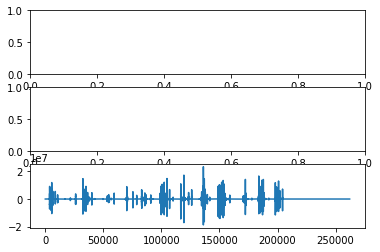

In [18]:
wt = DWTForward(J=3,wave='db10',mode='zero')
iwt = DWTInverse(wave='db10', mode='zero')

print(type(model_out[1]))
print(type(model_out[1][0]),model_out[1][0].size())
print(type(model_out[1][1]),[x.size() for x in model_out[1][1]])
print(model_out[1][0][0][0][0])
print("確認",wt(input_data[j].reshape(1,1,1,-1))[0].size(),wt(input_data[j].reshape(1,1,1,-1))[0][0][0][0])
#print("wの結果",type(model_out[1]),model_out[1].size(),'\n',model_out[1][j][0][0])
print("スパース解wをつかって求めた波形\n",iwt(model_out[1])[j][0][0])


check = iwt(model_out[1])
print(type(check),check.size())
plt.subplot(3,1,1)
#plt.plot(data.cpu(),true[j].cpu())
plt.subplot(3,1,2)
#plt.plot(data.cpu(),y_add_noise[j].cpu().detach().numpy())
plt.subplot(3,1,3)
plt.plot(data.cpu(),check[j][0][0].cpu().detach().numpy())


In [0]:
def w_softshrink(self,z,th):
    return [self.prox(x,th) for x in z]


In [20]:
"""
import torch
import math
import matplotlib.pyplot as plt
#import torch_dct as tdct
torch.set_default_tensor_type(torch.FloatTensor)

#b * cos(2 * pi * (1/x)) #(1/x) = f
a = torch.arange(0, 10, 0.0005)
b = torch.rand(20)
x = torch.arange(0.2,20,0.2)
y = 0
for i in range(0,9):
    y = y + b[i] * torch.cos(2 * math.pi * (1. /x[i]) * a) 
y[600] = y[600] + 2
y_add_noise = y + torch.rand(20000)
print(y)
print(y.size())
plt.subplot(4,1,1)
plt.plot(a,y)
plt.subplot(4,1,2)
plt.plot(a,y_add_noise)
dcty = tdct.dct(y_add_noise)
idcty = tdct.idct(dcty)
idcty = tdct.idct(softm(dcty,0))
plt.plot(a,idcty)
yfft = torch.rfft(y_add_noise,1)
print(yfft)
yfft = f_softshrink(yfft,100)
print(yfft)
yifft = torch.irfft(yfft,1,signal_sizes = y.shape)
print(yifft)
plt.subplot(4,1,3)
plt.plot(a,yifft)
plt.subplot(4,1,4)
#plt.plot(a,dcty)
plt.plot(torch.arange(19940),dcty[60:])
"""

'\nimport torch\nimport math\nimport matplotlib.pyplot as plt\n#import torch_dct as tdct\ntorch.set_default_tensor_type(torch.FloatTensor)\n\n#b * cos(2 * pi * (1/x)) #(1/x) = f\na = torch.arange(0, 10, 0.0005)\nb = torch.rand(20)\nx = torch.arange(0.2,20,0.2)\ny = 0\nfor i in range(0,9):\n    y = y + b[i] * torch.cos(2 * math.pi * (1. /x[i]) * a) \ny[600] = y[600] + 2\ny_add_noise = y + torch.rand(20000)\nprint(y)\nprint(y.size())\nplt.subplot(4,1,1)\nplt.plot(a,y)\nplt.subplot(4,1,2)\nplt.plot(a,y_add_noise)\ndcty = tdct.dct(y_add_noise)\nidcty = tdct.idct(dcty)\nidcty = tdct.idct(softm(dcty,0))\nplt.plot(a,idcty)\nyfft = torch.rfft(y_add_noise,1)\nprint(yfft)\nyfft = f_softshrink(yfft,100)\nprint(yfft)\nyifft = torch.irfft(yfft,1,signal_sizes = y.shape)\nprint(yifft)\nplt.subplot(4,1,3)\nplt.plot(a,yifft)\nplt.subplot(4,1,4)\n#plt.plot(a,dcty)\nplt.plot(torch.arange(19940),dcty[60:])\n'

In [21]:
"""
import torch
import math
import matplotlib.pyplot as plt
from pytorch_wavelets import DWTForward, DWTInverse
import torch_dct as tdct

maxnum = 10
#b * cos(2 * pi * (1/x)) #(1/x) = f
a = torch.arange(0, 10, 0.0005)
b = torch.rand(maxnum)
x = torch.arange(0.2,maxnum,0.2)
y = 0
for i in range(0,maxnum):
    y = y + b[i] * torch.cos(2 * math.pi * (1. /x[i]) * a) 
y[600] = y[600] + 5
y_add_noise = y + torch.rand(20000)
print(y)
print(y.size())
plt.subplot(5,1,1)
plt.plot(a,y)
plt.subplot(5,1,2)
plt.plot(a,y_add_noise)

wty = DWTForward(J=3, wave="db10", mode='zero')
iwty = DWTInverse(wave="db10", mode='zero')
Yl, Yh = wty(y_add_noise.view(1,1,1,y.size()[0]))
Yh = [softm(x,100) for x in Yh]
iwtyy = iwty((Yl,Yh))
print(iwtyy)
plt.subplot(5,1,3)
plt.plot(a,iwtyy[0][0][0])

dcty = tdct.dct(y_add_noise)
dcty = softm(dcty,200)
idcty = tdct.idct(dcty)
plt.subplot(5,1,4)
plt.plot(a,idcty)
print(idcty)

yfft = torch.rfft(y_add_noise,1)
yfft = f_softshrink(yfft,200)
yifft = torch.irfft(yfft,1,signal_sizes = y.shape)
print(yifft)
plt.subplot(5,1,5)
plt.plot(a,yifft)

print(torch.abs((y - idcty).sum()))
print(torch.abs((y - yifft).sum()))
"""

'\nimport torch\nimport math\nimport matplotlib.pyplot as plt\nfrom pytorch_wavelets import DWTForward, DWTInverse\nimport torch_dct as tdct\n\nmaxnum = 10\n#b * cos(2 * pi * (1/x)) #(1/x) = f\na = torch.arange(0, 10, 0.0005)\nb = torch.rand(maxnum)\nx = torch.arange(0.2,maxnum,0.2)\ny = 0\nfor i in range(0,maxnum):\n    y = y + b[i] * torch.cos(2 * math.pi * (1. /x[i]) * a) \ny[600] = y[600] + 5\ny_add_noise = y + torch.rand(20000)\nprint(y)\nprint(y.size())\nplt.subplot(5,1,1)\nplt.plot(a,y)\nplt.subplot(5,1,2)\nplt.plot(a,y_add_noise)\n\nwty = DWTForward(J=3, wave="db10", mode=\'zero\')\niwty = DWTInverse(wave="db10", mode=\'zero\')\nYl, Yh = wty(y_add_noise.view(1,1,1,y.size()[0]))\nYh = [softm(x,100) for x in Yh]\niwtyy = iwty((Yl,Yh))\nprint(iwtyy)\nplt.subplot(5,1,3)\nplt.plot(a,iwtyy[0][0][0])\n\ndcty = tdct.dct(y_add_noise)\ndcty = softm(dcty,200)\nidcty = tdct.idct(dcty)\nplt.subplot(5,1,4)\nplt.plot(a,idcty)\nprint(idcty)\n\nyfft = torch.rfft(y_add_noise,1)\nyfft = f_softshr

In [22]:
"""
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import fftpack

#b * cos(2 * pi * (1/x)) #(1/x) = f
a = np.arange(0, 10, 0.0005)
b = np.random.rand(9)
x = np.arange(0.02,2,0.05)
y = np.zeros(len(a))
for i in range(0,9):
    y = y + b[i] * np.cos(2 * math.pi * (1. /x[i]) * a) 
print(y)
y = y #+ np.random.rand(len(y)) * 3
print(len(y))
print(x.size)
plt.subplot(2,1,1)
plt.plot(a,y)

ydct = fftpack.dct(y,norm='ortho')
yidct = fftpack.idct(ydct,norm='ortho')
plt.subplot(2,1,2)
plt.plot(a,yidct)
print(y)
print(ydct)
print(yidct)
print(y - yidct)
print((np.fabs(y - yidct)).sum())
assert (y - yidct).sum() < 1e-10
"""

"\nimport numpy as np\nimport math\nimport matplotlib.pyplot as plt\nfrom scipy import fftpack\n\n#b * cos(2 * pi * (1/x)) #(1/x) = f\na = np.arange(0, 10, 0.0005)\nb = np.random.rand(9)\nx = np.arange(0.02,2,0.05)\ny = np.zeros(len(a))\nfor i in range(0,9):\n    y = y + b[i] * np.cos(2 * math.pi * (1. /x[i]) * a) \nprint(y)\ny = y #+ np.random.rand(len(y)) * 3\nprint(len(y))\nprint(x.size)\nplt.subplot(2,1,1)\nplt.plot(a,y)\n\nydct = fftpack.dct(y,norm='ortho')\nyidct = fftpack.idct(ydct,norm='ortho')\nplt.subplot(2,1,2)\nplt.plot(a,yidct)\nprint(y)\nprint(ydct)\nprint(yidct)\nprint(y - yidct)\nprint((np.fabs(y - yidct)).sum())\nassert (y - yidct).sum() < 1e-10\n"